<a href="https://colab.research.google.com/github/maxbentley/datasciencefund/blob/main/Unit9/Unit_9_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 9 (final!) Project: Classifying Presidential Debate Candidates

I don't really like politics. It's so complicated! I don't really know what a Democrat or a Republican is. But what I do know is baseball: and thankfully, every year, members of Congress from the two parties hold the Congressional Baseball Game for Charity, where I can finally tune into the political process stress-free as they duke it out for a good cause. What's not to love?

But when I was watching the game in 2018, something felt different. There was an sense of mystique in the air, as if a momentous event had just happened. Something--or someone--was about to change the world as we knew it. Over his eight-game career in the Congressional Baseball Game, he [would go on to hit for a 138 wRC+ (where 100 is average) with a full season pace of four wins above replacement](https://docs.google.com/spreadsheets/d/1ugXP6qar3m3jmKtjsUp-AFWLyVeQOOK-3b9DblPTRks/edit?gid=0#gid=0/). Who was this mystical man?

All would become clear in due time. On April 4th, 2019, the disruptor revealed himself to be Tim Ryan, the Democratic representative for Ohio's Akron-based 13th congressional district and who was rivaled in cultural impact only by fellow Northeast Ohio native LeBron James. I quickly rallied behind his campaign, for the purpose of shaking up a system in desperate need of being flung against the wall by the legs. I wanted so desperately to see my baby boy on TV again alongside all of the career insider politicians like Bernie Sanders who paid their way to the debate stage. I got everybody I could to donate money to his campaign to meet the donor requirement and registered multiple fake names in the voter registry in order to increase the likelihood that I could scream "TIM RYAN" to a lowly New York Times reporter conducting a poll over the phone.

At long last, the debate field was announced: he would go on the first night, alongside nine other candidates. But when I turned on the television, hoping to see the Timinator destroy his competition, most of the time the only people that were on screen had names like "Elizabeth Warren" or "Beto O'Rourke". Who are all of these people? What do they look like? It was so hard for me to keep track of all of these nobodies. That's why I decided, for my final project, to have the computer do the job for me using a Convolutional Neural Network (CNN).

## I just LIED to you!

Sadly, finding an online dataset (much less a well-maintained one) of relatively obscure political figures is near-impossible, and creating one within a week is an expensive hassle that I wouldn't wish on my worst enemy. So I'm going to change my project: I'm going to try and classify the four Generation 1 starter pokemon (Bulbasaur, Charmander, Pikachu and Squirtle) using [a dataset I found on Kaggle](https://www.kaggle.com/datasets/thedagger/pokemon-generation-one/data), still using a CNN.

## What's a convolutional neural network?

It's a neural network with **convolutional layers** inside of it. Here's the formal definition of a convolution, copied from Google:

![(f*g)(t) = the integral from -infinity to infinity of f(tau)g(t-tau)tau', where (f*g)(t) are the functions being convoluted, t is the real number variable of functions f and g, g(tau) is the convolutions of the function f(t) and tau' is the first derivative of the g(tau) function](https://drive.google.com/uc?export=view&id=1RLsFO0BshymrpvDcT7iWOsZ41I2PIuZ_)

It looks like one of those equations that flashes past a character in a movie's head while they're thinking in order to show you that they're smart. What it's doing in the neural network is actually relatively simple, though. Instead of taking in some input, assigning some different "weights" to it, and outputting that multiplied matrix, as in a traditional NN "layer", it does a different operation, called a convolution:<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) it takes a matrix with varying weights and uses that matrix (called the "kernel") to change each element in the matrix to a moving average of the surrounding elements, using the different weights to inform the average. If that doesn't make sense, [here's a link to better explanation of what a convolution is](https://www.youtube.com/watch?v=KuXjwB4LzSA) from 3blue1brown's Grant Sanderson, a person who's a lot smarter than I am and whose job it is to explain math. (I also highly recommend you watch [his other series on neural networks](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi), if like me, you were a little confused as to what exactly those 5 steps the notes talked about were doing.) Below is a commonly-used GIF to explain what a convolution actually does, copied from [here](https://glassboxmedicine.com/2019/07/26/convolution-vs-cross-correlation/).

![Animation of a convolution](https://glassboxmedicine.com/wp-content/uploads/2019/07/convgif.gif)

Why would we want to do that? There are actually a lot of different use cases for convolutions. If you've ever used a "gaussian blur" in Photoshop or some other image manipulation software, that's using a convolution, taking an average of the surrounding pixels through sampling a normal distribution. Convolutions are everywhere in probability, largely due to the fact that adding two probability distributions is a convolution. The primary use case we're going to be looking at, though, is going to attempt to use edge detection to figure out the minute details in each Pokemon. At least, that's what I think it's going to be doing.

## Data Wrangling

Much of the following code was taken from tutorials at [learnpytorch.io](https://www.learnpytorch.io/04_pytorch_custom_datasets/).

If you want to skip all of the code, here are the headlines:

One of the biggest hurdles with CNNs is that making and cleaning datasets is a lot more involved, since you're more likely than not working with formats that are a bit more complicated than just spreadsheets--you're working with images, audio, etc. This requires a lot more processing power, so I switched Colab to running on the GPU instead of CPU cores, which are slower.

Importing the dataset is pretty tough on its own - to simplify, I just uploaded the dataset to my Google Drive and mounted it instead of having to deal with Colab's filesystem without terminal access.

A common way to help train NNs is to apply a bunch of random transformations to the training dataset to "augment" the data or increase the size of the dataset - this is supposed to make the model learn more effectively, as it has more examples to go off of.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import libraries
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torch import nn
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [3]:
# import specific directory from drive
from pathlib import Path
image_path = Path('/content/drive/MyDrive/pokemon_dataset')

In [4]:
image_path_jpg = list(image_path.glob('*/*.jpg')) # need both pngs and jpgs
image_path_png = list(image_path.glob('*/*.png'))
image_path_list = image_path_jpg + image_path_png

# setup train/testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

In [ ]:
# create test and train directories by moving images from pokemon directory to test/train

def create_test_and_train(dir_path):
  file_count = 0
  for entry in os.scandir(dir_path):
      if entry.is_file():
          file_count += 1
          cool = entry.path.split(sep='/')
          if file_count < 200: # first 200 files in each pokemon directory (~70%) go into the training data
            os.rename(entry.path, f'/content/drive/MyDrive/pokemon_dataset/train/{cool[-2]}/{cool[-1]}')
          else:                # rest go into the test data
            os.rename(entry.path, f'/content/drive/MyDrive/pokemon_dataset/test/{cool[-2]}/{cool[-1]}')
      elif entry.is_dir():
          file_count = 0
          print(f"Directory: {entry.path}")
          create_test_and_train(entry.path)  # Recursive call for subdirectories

create_test_and_train(image_path)

Directory: /content/drive/MyDrive/pokemon_dataset/Bulbasaur
Directory: /content/drive/MyDrive/pokemon_dataset/Charmander
Directory: /content/drive/MyDrive/pokemon_dataset/Pikachu
Directory: /content/drive/MyDrive/pokemon_dataset/Squirtle
Directory: /content/drive/MyDrive/pokemon_dataset/train
Directory: /content/drive/MyDrive/pokemon_dataset/train/Bulbasaur
Directory: /content/drive/MyDrive/pokemon_dataset/train/Squirtle
Directory: /content/drive/MyDrive/pokemon_dataset/train/Charmander
Directory: /content/drive/MyDrive/pokemon_dataset/train/Pikachu
Directory: /content/drive/MyDrive/pokemon_dataset/test
Directory: /content/drive/MyDrive/pokemon_dataset/test/Bulbasaur
Directory: /content/drive/MyDrive/pokemon_dataset/test/Squirtle
Directory: /content/drive/MyDrive/pokemon_dataset/test/Pikachu
Directory: /content/drive/MyDrive/pokemon_dataset/test/Charmander


In [ ]:
# ran the above code twice (oops!) so i had to run it again

create_test_and_train(image_path / 'train')

Directory: /content/drive/MyDrive/pokemon_dataset/train/Bulbasaur
Directory: /content/drive/MyDrive/pokemon_dataset/train/Squirtle
Directory: /content/drive/MyDrive/pokemon_dataset/train/Charmander
Directory: /content/drive/MyDrive/pokemon_dataset/train/Pikachu


In [5]:
# Transform images to make it harder for the CNN to learn, hopefully increasing accuracy
data_transform = v2.Compose([
    # Resize the images to 64x64
    v2.Resize(size=(64, 64)),
    # Do a whole bunch of transformations
    v2.TrivialAugmentWide(num_magnitude_bins=26),
    # Turn the image into a torch.Tensor
    v2.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [6]:
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 795
    Root location: /content/drive/MyDrive/pokemon_dataset/train
    StandardTransform
Transform: Compose(
                 Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 TrivialAugmentWide(interpolation=InterpolationMode.NEAREST, num_magnitude_bins=26)
                 ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 373
    Root location: /content/drive/MyDrive/pokemon_dataset/test
    StandardTransform
Transform: Compose(
                 Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 TrivialAugmentWide(interpolation=InterpolationMode.NEAREST, num_magnitude_bins=26)
                 ToTensor()
           )


In [7]:
class_names = train_data.classes
class_names

['Bulbasaur', 'Charmander', 'Pikachu', 'Squirtle']

In [8]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
from typing import Dict, List

# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

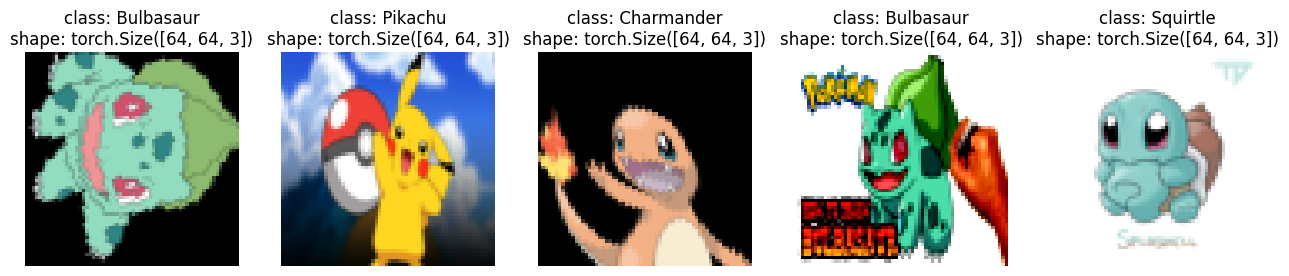

In [ ]:
display_random_images(train_data, n = 5, classes = class_names, seed = None)

As you can see, the training data isn't perfect, but it's hopefully good enough.

In [10]:
# make DataLoader object from Dataset object, which makes the dataset iterable

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32, # how many samples per batch?
                              num_workers=os.cpu_count(), # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             num_workers=os.cpu_count(),
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fdf462b0cd0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fdf462e30d0>)

## Let's make a model!

Again, much of the code below is copied and/or slightly modified from [learnpytorch.io](https://www.learnpytorch.io/03_pytorch_computer_vision/).

In [ ]:
!pip install torchmetrics
from torchmetrics import Accuracy # evaluates model on how accurate its predictions are

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

My first attempt is pretty simple: just a single convolutional layer (kernel size of 3) followed by a ReLU activation. I doubt this is actually going to work very well, since it's a very simple model on its own, but it'll give me a better idea of how to continue.

In [11]:
class attempt_1(torch.nn.Module):

    # initializes the model.
    # input_shape = color channels (3, RGB), hidden_units = "neurons", output_shape = # of classes
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.layer_1 = nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3, # how big is the square that's going over the image?
                  stride=1, # default
                  padding=1) # output has same shape as input
        self.layer_2 = nn.ReLU()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*64*64, # 64 * 64
                      out_features=output_shape)
        )


    def forward(self, x: torch.Tensor):
        return self.classifier(self.layer_2(self.layer_1(x)))

In [12]:
model_1 = attempt_1(input_shape=3,
                    hidden_units=10,
                    output_shape=4).to(device)

# Create a loss function
loss_fn = torch.nn.CrossEntropyLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

### saving space (methods for training)

In [13]:
# this function was directly copied from learnpytorch.io

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [14]:
# ditto for this function

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [15]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### run model!

In [16]:
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=5)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 1 | train_loss: 2.7854 | train_acc: 0.2516 | test_loss: 1.3866 | test_acc: 0.2552


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 2 | train_loss: 1.3859 | train_acc: 0.2591 | test_loss: 1.3844 | test_acc: 0.3073


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 3 | train_loss: 1.4586 | train_acc: 0.2919 | test_loss: 1.3876 | test_acc: 0.2526


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 4 | train_loss: 1.3876 | train_acc: 0.2341 | test_loss: 1.3869 | test_acc: 0.2526


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 5 | train_loss: 1.3876 | train_acc: 0.2384 | test_loss: 1.3866 | test_acc: 0.2500
Total training time: 526.369 seconds


That's not very good. The accuracy (test_acc) hovers a little over 25%, which is only slightly better than how you would do if you were just randomly guessing.

Let's visualize the loss curves for this model (function code copied from learnpytorch.io)

In [17]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

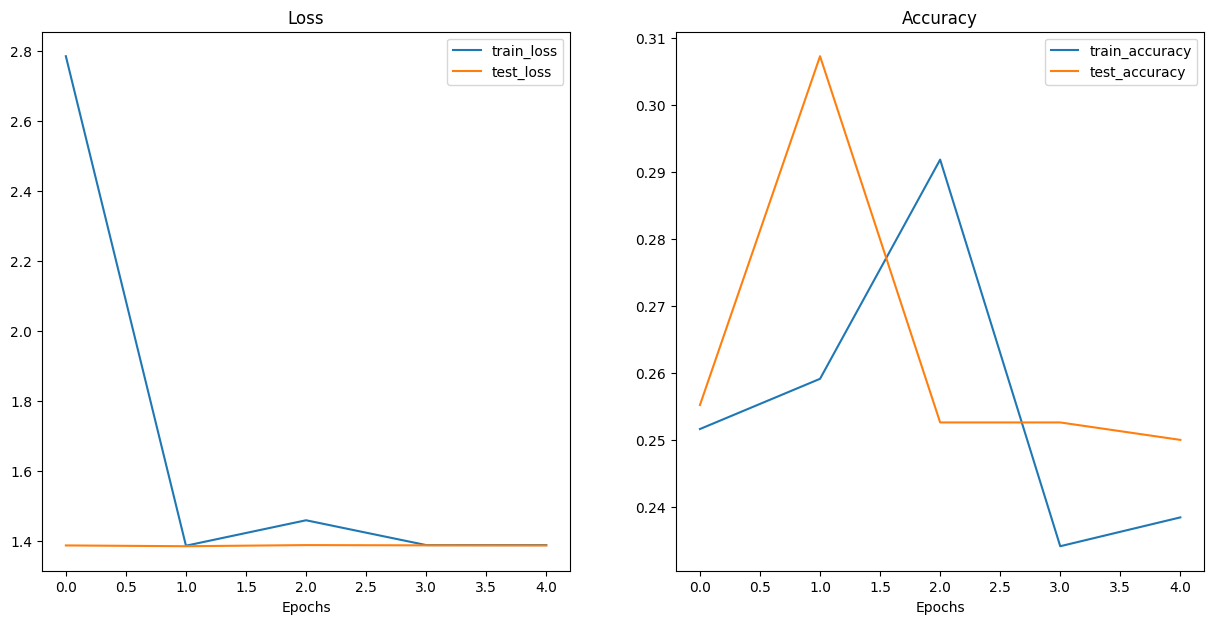

In [18]:
plot_loss_curves(model_1_results)

This is terrible! It's super noisy and basically not learning anything.

Let's add a few more layers to our model. Below is the TinyVGG model, a commonly used image recognition model to explain how CNNs work, as seen on this helpful [CNN Explainer](https://poloclub.github.io/cnn-explainer/). It consists of four convolutional layers, four ReLU activations and two 2D Max Pool layers, which take the better of the two previously-run layers.

In [19]:
# below model is the same as the TinyVGG model on learnpytorch.io, but with less readable code (sorry)

class attempt_2(torch.nn.Module):

    # initializes the model.
    # input_shape = color channels (3, RGB), hidden_units = "neurons", output_shape = # of classes
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.layer_1 = nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3, # how big is the square that's going over the image?
                  stride=1, # default
                  padding=1) # output has same shape as input
        self.layer_2 = nn.ReLU()

        self.layer_3 = nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1)
        self.layer_4 = nn.ReLU()

        self.layer_41 = nn.MaxPool2d(kernel_size=2, # finds best changes from previous layers
                               stride=2)

        self.layer_5 = nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1)
        self.layer_6 = nn.ReLU()

        self.layer_7 = nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1)
        self.layer_8 = nn.ReLU()
        self.layer_81 = nn.MaxPool2d(kernel_size=2,
                               stride=2)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )


    def forward(self, x: torch.Tensor):
        x = self.layer_2(self.layer_1(x))
        x = self.layer_4(self.layer_3(x))
        x = self.layer_41(x)
        x = self.layer_6(self.layer_5(x))
        x = self.layer_8(self.layer_7(x))
        return self.classifier(self.layer_81(x))

In [21]:
model_2 = attempt_2(input_shape=3,
                    hidden_units=10,
                    output_shape=4).to(device)

optimizer_2 = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

start_time = timer()

# Train model_0
model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer_2,
                        loss_fn=loss_fn,
                        epochs=5)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 1 | train_loss: 1.3876 | train_acc: 0.2576 | test_loss: 1.3851 | test_acc: 0.2592


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 2 | train_loss: 1.3819 | train_acc: 0.2889 | test_loss: 1.3676 | test_acc: 0.4020


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 3 | train_loss: 1.3696 | train_acc: 0.3114 | test_loss: 1.3881 | test_acc: 0.2370


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 4 | train_loss: 1.3876 | train_acc: 0.2512 | test_loss: 1.3858 | test_acc: 0.2422


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 5 | train_loss: 1.3806 | train_acc: 0.2933 | test_loss: 1.3988 | test_acc: 0.2344
Total training time: 122.854 seconds


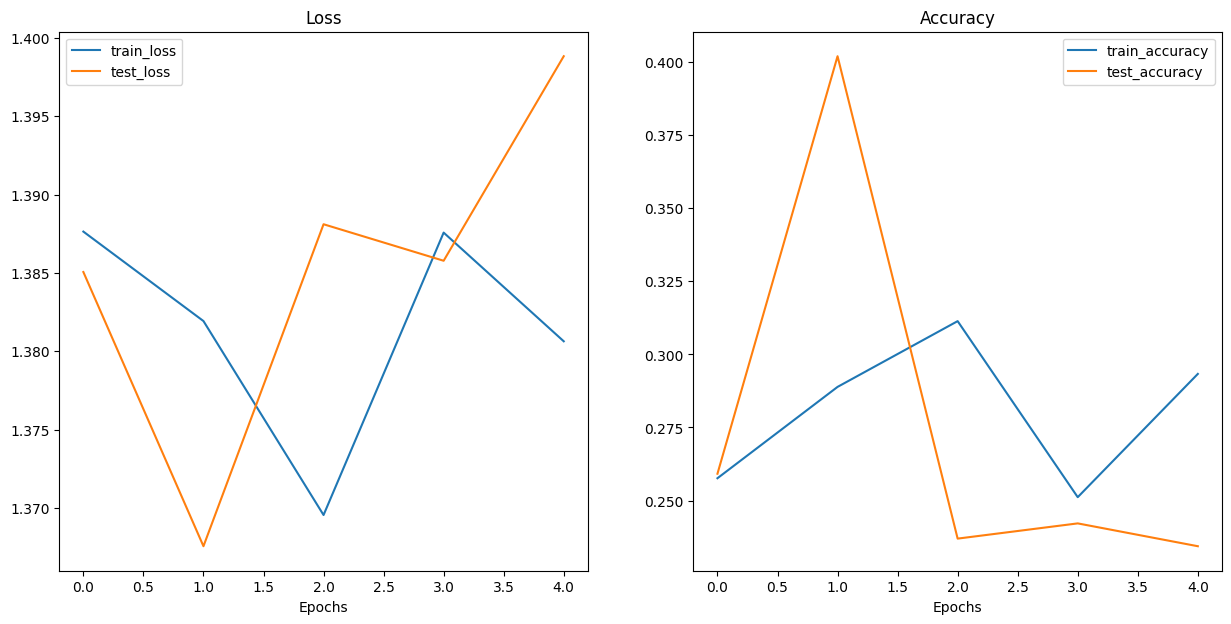

In [22]:
plot_loss_curves(model_2_results)

The model isn't improving that much over the previous one, and arguably it's getting worse; the loss is pretty noisy and the accuracy is still remaining small (outside of a random spike in epoch 2). It also is seemingly overfitting in the last several epochs. This is interesting given that the architecture is relatively well-known: TinyVGG is often used as a way of teaching people how image recognition using CNNs work, so it should have worked somewhat well on its own.

Let's set our sights on some other way of improving the model outside of the structure itself. I set the learning rate of the optimizer to 0.1, which might be pretty high; let's see what happens when we lower it by a factor of 100.

In [154]:
model_3 = attempt_1(input_shape=3,
                    hidden_units=10,
                    output_shape=4).to(device)

optimizer_mod_1 = torch.optim.SGD(params=model_3.parameters(), lr=0.001)

start_time = timer()

# Train model_0
model_3_results = train(model=model_3,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer_mod_1,
                        loss_fn=loss_fn,
                        epochs=5)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 1 | train_loss: 1.3995 | train_acc: 0.2412 | test_loss: 1.3894 | test_acc: 0.2540


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 2 | train_loss: 1.3480 | train_acc: 0.3504 | test_loss: 1.3559 | test_acc: 0.3466


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 3 | train_loss: 1.3022 | train_acc: 0.4104 | test_loss: 1.2831 | test_acc: 0.4185


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 4 | train_loss: 1.2444 | train_acc: 0.4481 | test_loss: 1.3376 | test_acc: 0.3281


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 5 | train_loss: 1.1815 | train_acc: 0.5227 | test_loss: 1.1932 | test_acc: 0.4945
Total training time: 115.261 seconds


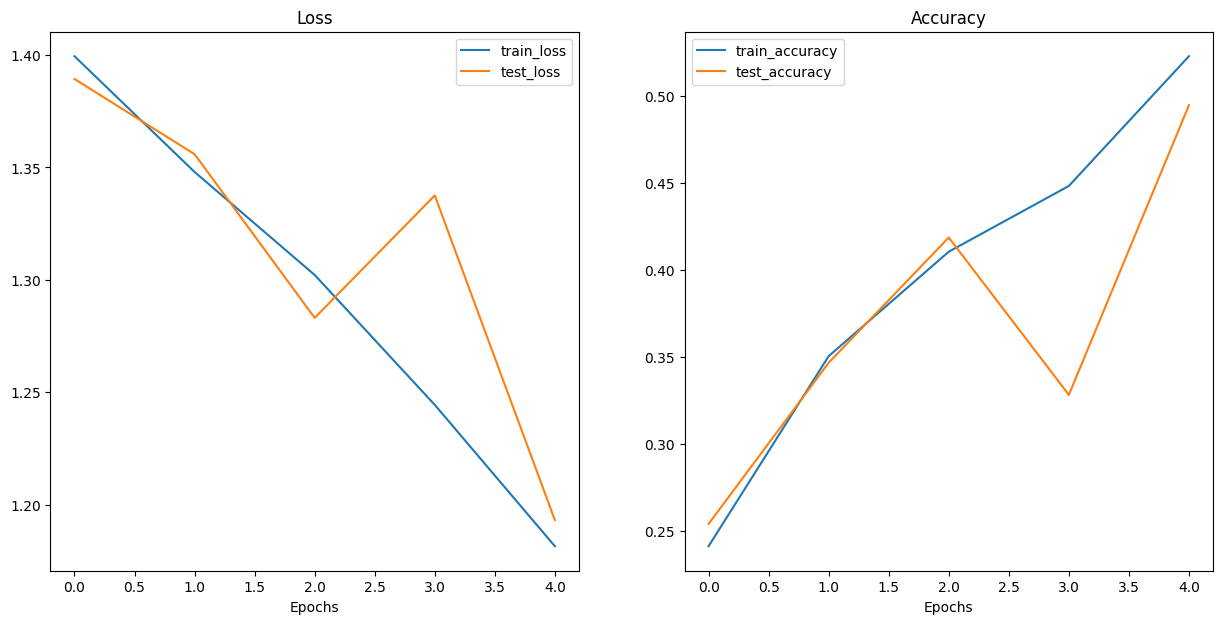

In [155]:
plot_loss_curves(model_3_results)

Whoa! That's a *lot* better. There's actually some sort of trend with our accuracy and loss, which is a great sign. It's even getting to double the accuracy as the other one, which is really good! Let's see how the other architecture does:

In [40]:
model_4 = attempt_2(input_shape=3,
                    hidden_units=10,
                    output_shape=4).to(device)

optimizer_mod_2 = torch.optim.SGD(params=model_4.parameters(), lr=0.001)

start_time = timer()

# Train model_0
model_4_results = train(model=model_4,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer_mod_2,
                        loss_fn=loss_fn,
                        epochs=5)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 1 | train_loss: 1.3868 | train_acc: 0.2504 | test_loss: 1.3862 | test_acc: 0.2474


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 2 | train_loss: 1.3865 | train_acc: 0.2491 | test_loss: 1.3864 | test_acc: 0.2500


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 3 | train_loss: 1.3866 | train_acc: 0.2516 | test_loss: 1.3864 | test_acc: 0.2474


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 4 | train_loss: 1.3866 | train_acc: 0.2496 | test_loss: 1.3863 | test_acc: 0.2500


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 5 | train_loss: 1.3866 | train_acc: 0.2519 | test_loss: 1.3863 | test_acc: 0.2422
Total training time: 122.733 seconds


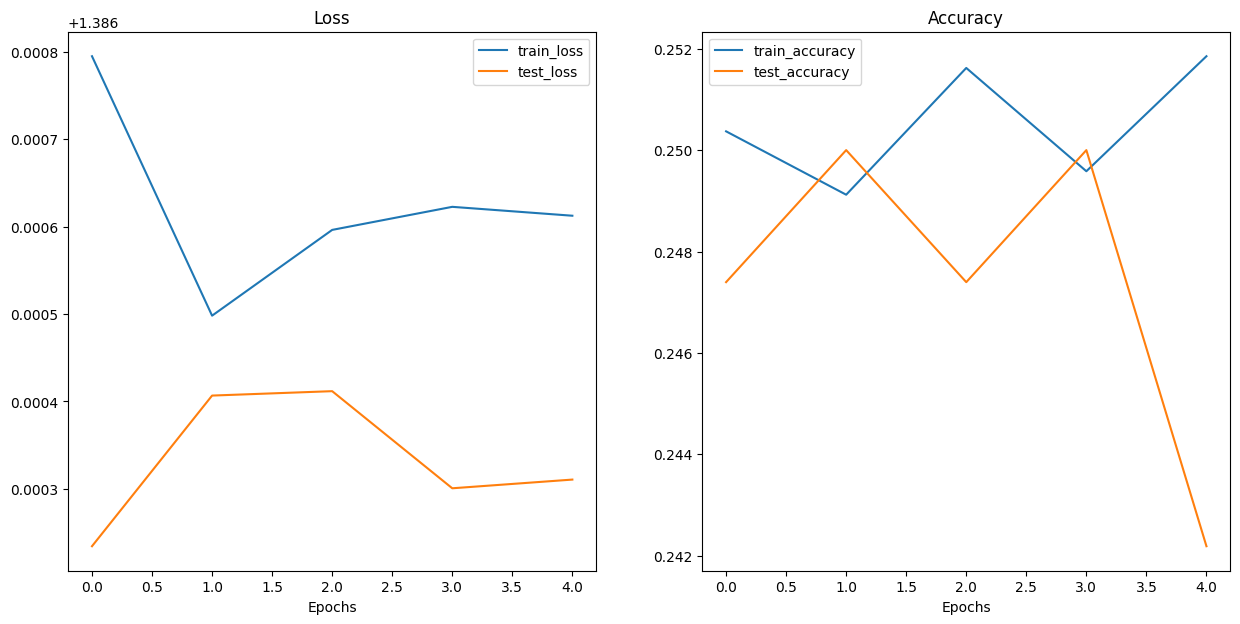

In [41]:
plot_loss_curves(model_4_results)

Changing the learning rate of this model didn't improve anything at all, which is interesting considering that this is a more "well-known" architecture for this type of thing.

It seems like the simplest model worked the best here. My best guess is that that architecture could just not be better suited for this particular task: the CNN Explainer website tries to classify multiple different things, ranging from pizzas to cars to koalas; this model is only trying to classify four different Pokemon, which are all relatively similar.

Just for kicks, let's see what happens if we have just two convolutional layers instead of one:

In [44]:
class attempt_3(torch.nn.Module):

    # initializes the model.
    # input_shape = color channels (3, RGB), hidden_units = "neurons", output_shape = # of classes
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.layer_1 = nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3, # how big is the square that's going over the image?
                  stride=1, # default
                  padding=1) # output has same shape as input
        self.layer_2 = nn.ReLU()
        self.layer_3 = nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1)
        self.layer_4 = nn.ReLU()
        self.layer_41 = nn.MaxPool2d(kernel_size=2, # finds best changes from previous layers
                               stride=2)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*64*64, # 64 * 64
                      out_features=output_shape)
        )


    def forward(self, x: torch.Tensor):
        return self.classifier(self.layer_2(self.layer_1(x)))

In [45]:
model_5 = attempt_3(input_shape=3,
                    hidden_units=10,
                    output_shape=4).to(device)

optimizer_5 = torch.optim.SGD(params=model_5.parameters(), lr=0.001)

start_time = timer()

# Train model_0
model_4_results = train(model=model_5,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer_5,
                        loss_fn=loss_fn,
                        epochs=5)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 1 | train_loss: 1.3963 | train_acc: 0.2854 | test_loss: 1.3073 | test_acc: 0.3374


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 2 | train_loss: 1.2980 | train_acc: 0.3998 | test_loss: 1.2333 | test_acc: 0.4597


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 3 | train_loss: 1.2008 | train_acc: 0.4508 | test_loss: 1.2267 | test_acc: 0.4312


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 4 | train_loss: 1.1532 | train_acc: 0.4903 | test_loss: 1.1355 | test_acc: 0.4702


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 5 | train_loss: 1.0943 | train_acc: 0.5472 | test_loss: 1.0993 | test_acc: 0.5124
Total training time: 117.823 seconds


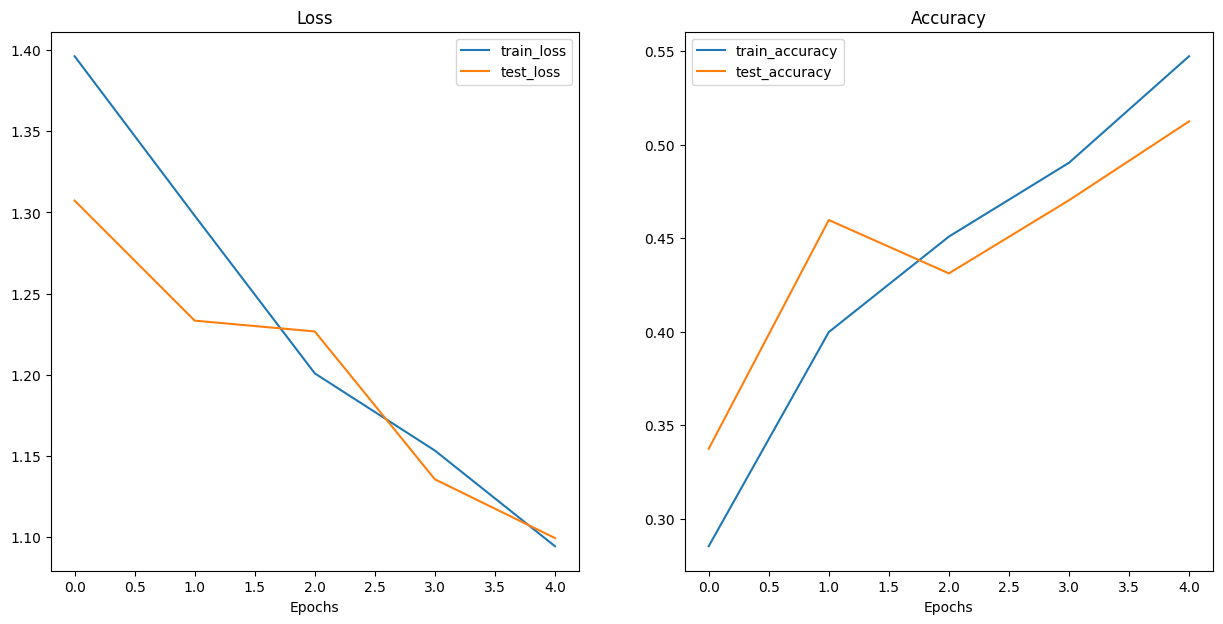

In [47]:
plot_loss_curves(model_4_results)

That's pretty good - even better than my subsequent runs of model 3. It seems that simple models work best.

### Final evaluation

To test all of the models one final time, I'll see how they do with an image not in the training set.

In [148]:
import torchvision

custom_image_path = image_path / "Charmander.jpg"

custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

custom_image = custom_image / 255

custom_transform = v2.Compose([
    v2.Resize((64, 64)),
])

custom_image_transformed = custom_transform(custom_image)

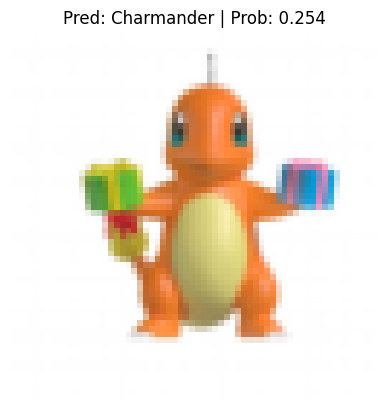

In [149]:
model_1.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error

plt.imshow(custom_image_transformed.unsqueeze(dim=0).squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
if class_names:
    title = f"Pred: {class_names[custom_image_pred_label.cpu()]} | Prob: {custom_image_pred_probs.max().cpu():.3f}"
else:
    title = f"Pred: {custom_image_pred_label} | Prob: {custom_image_pred_probs.max().cpu():.3f}"
plt.title(title)
plt.axis(False);

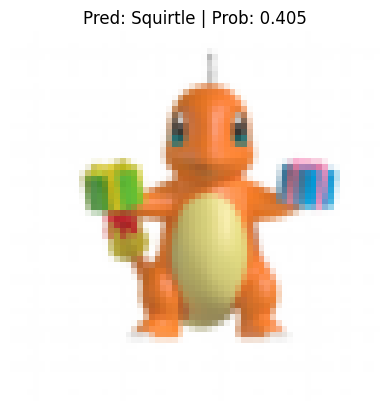

In [150]:
model_2.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_pred = model_2(custom_image_transformed.unsqueeze(dim=0).to(device))

custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error

plt.imshow(custom_image_transformed.unsqueeze(dim=0).squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
if class_names:
    title = f"Pred: {class_names[custom_image_pred_label.cpu()]} | Prob: {custom_image_pred_probs.max().cpu():.3f}"
else:
    title = f"Pred: {custom_image_pred_label} | Prob: {custom_image_pred_probs.max().cpu():.3f}"
plt.title(title)
plt.axis(False);

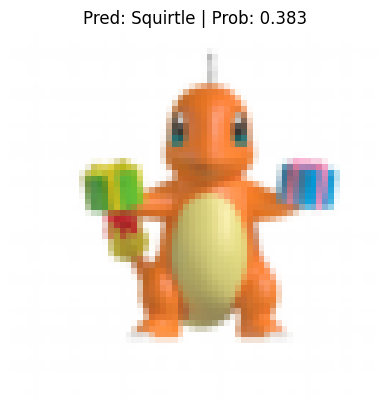

In [156]:
model_3.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_pred = model_3(custom_image_transformed.unsqueeze(dim=0).to(device))

custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error

plt.imshow(custom_image_transformed.unsqueeze(dim=0).squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
if class_names:
    title = f"Pred: {class_names[custom_image_pred_label.cpu()]} | Prob: {custom_image_pred_probs.max().cpu():.3f}"
else:
    title = f"Pred: {custom_image_pred_label} | Prob: {custom_image_pred_probs.max().cpu():.3f}"
plt.title(title)
plt.axis(False);

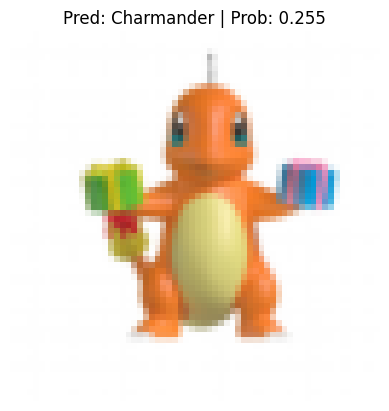

In [152]:
model_4.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_pred = model_4(custom_image_transformed.unsqueeze(dim=0).to(device))

custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error

plt.imshow(custom_image_transformed.unsqueeze(dim=0).squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
if class_names:
    title = f"Pred: {class_names[custom_image_pred_label.cpu()]} | Prob: {custom_image_pred_probs.max().cpu():.3f}"
else:
    title = f"Pred: {custom_image_pred_label} | Prob: {custom_image_pred_probs.max().cpu():.3f}"
plt.title(title)
plt.axis(False);

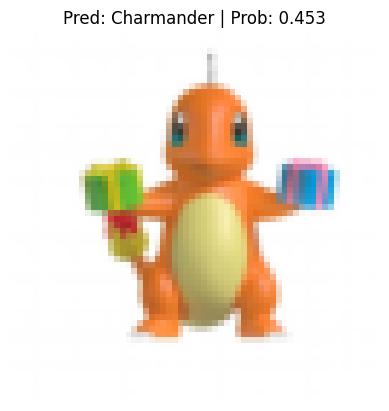

In [153]:
model_5.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_pred = model_5(custom_image_transformed.unsqueeze(dim=0).to(device))

custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error

plt.imshow(custom_image_transformed.unsqueeze(dim=0).squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
if class_names:
    title = f"Pred: {class_names[custom_image_pred_label.cpu()]} | Prob: {custom_image_pred_probs.max().cpu():.3f}"
else:
    title = f"Pred: {custom_image_pred_label} | Prob: {custom_image_pred_probs.max().cpu():.3f}"
plt.title(title)
plt.axis(False);

I'm gonna be honest, looking at these results makes me think I could probably do a lot better. The best model still only barely cracked 50% accuracy, and trying out different images on each of these models leaves me super unsatisfied that any one model is much better than the rest. On this Charmander image, model 5 is far and away the best, on other images, it's a lot less correct; on some images, model 3 works the best, on this one it's pretty bad.

Let's try running models 3 and 5 a bit longer, considering those worked the best.

In [157]:
model_3 = attempt_1(input_shape=3,
                    hidden_units=10,
                    output_shape=4).to(device)

optimizer_mod_1 = torch.optim.SGD(params=model_3.parameters(), lr=0.001)

start_time = timer()

# Train model_0
model_3_results_new = train(model=model_3,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer_mod_1,
                        loss_fn=loss_fn,
                        epochs=10)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 1 | train_loss: 1.3773 | train_acc: 0.3116 | test_loss: 1.3966 | test_acc: 0.2592


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 2 | train_loss: 1.2533 | train_acc: 0.4220 | test_loss: 1.2361 | test_acc: 0.3803


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 3 | train_loss: 1.1715 | train_acc: 0.4990 | test_loss: 1.1918 | test_acc: 0.4490


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 4 | train_loss: 1.1365 | train_acc: 0.5180 | test_loss: 1.1438 | test_acc: 0.5041


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 5 | train_loss: 1.0705 | train_acc: 0.5845 | test_loss: 1.0903 | test_acc: 0.5776


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 6 | train_loss: 1.0529 | train_acc: 0.5875 | test_loss: 1.0806 | test_acc: 0.5942


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 7 | train_loss: 1.0440 | train_acc: 0.5712 | test_loss: 1.0605 | test_acc: 0.5290


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 8 | train_loss: 0.9835 | train_acc: 0.5911 | test_loss: 1.0325 | test_acc: 0.6064


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 9 | train_loss: 0.9868 | train_acc: 0.6129 | test_loss: 1.0223 | test_acc: 0.6208


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 10 | train_loss: 0.9576 | train_acc: 0.6327 | test_loss: 1.0495 | test_acc: 0.5596
Total training time: 238.908 seconds


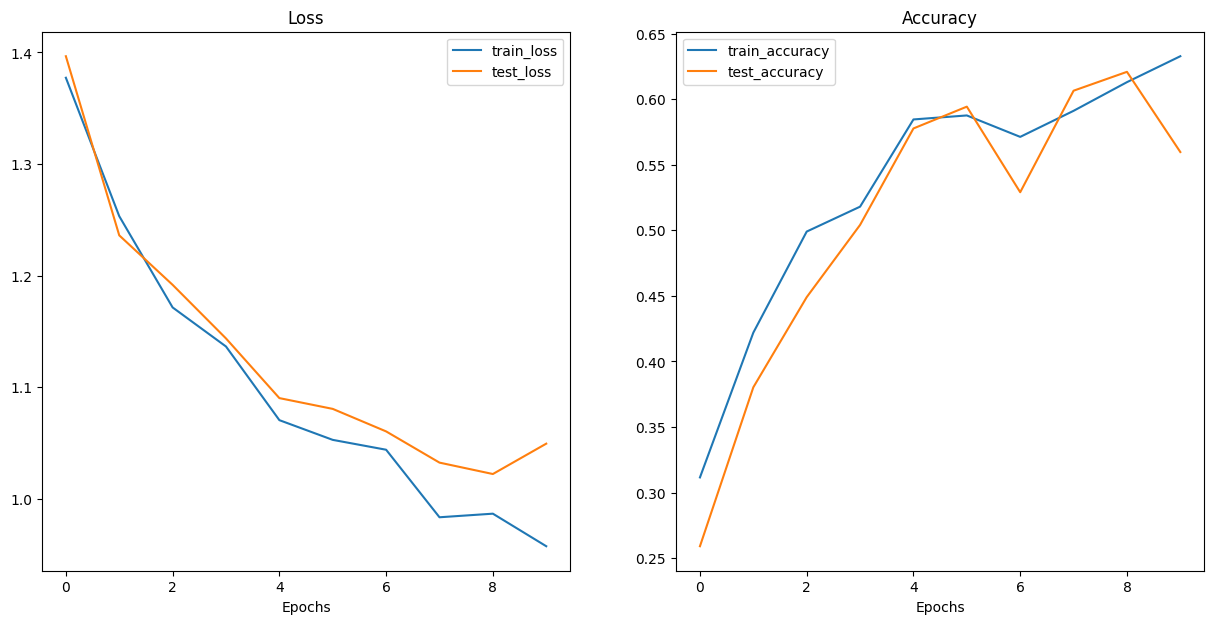

In [158]:
plot_loss_curves(model_3_results_new)

Unfortunate. Running the model for longer doesn't seem to improve it all that much.

I was hoping to analyze this a bit more, but I reached the colab compute limit, probably because I both switched my runtime to the GPU when I was doing data wrangling (which did not utilize the GPU) and ran my best-performing models like 10 times to see if any changes would be made in their findings for some reason. Oops! Lesson learned, and project done.

## Footnotes

<a name="cite_note-1"></a>1. [^](#cite_ref-1) Technically, to save computation time, it's not actually doing a convolution, rather a cross-correlation (the difference is that convolutions flip the kernel along the middle row before computing the average). Both operations produce the same result, as the weights are just learned in the opposite order. I'll keep calling them convolutions for simplicity, as that's the more commonly used term.